## Rosbank ML Competition

Участие в соревновании, проводимое на платформе Boosters: ссылка на соревнование и данные: https://boosters.pro/champ_15#
Соревнование состоит из двух задач:

**Задача 1.**

В первой задаче вам предстоит решить задачу бинарной классификации – спрогнозировать отток клиентов.
Метрика - AUC

**Задача 2.**

Во второй задаче вам нужно предсказать объём транзакций через POS-терминал за следующие три месяца использования продукта.
Метрика - RMSLE

На обе задачи участникам даётся один датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
#from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV,RandomizedSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Загрузка и первоначальная обработка данных

In [2]:
train = pd.read_csv('../data/rbtest/train.csv')
test = pd.read_csv('../data/rbtest/test.csv')

In [3]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


#### Вот так выглядят данные: 10 признаков, в 1 (channel_type) есть пропущенные значения. Сделаем следующе:
- заменим пропущенные значения в channel_type на 'unknown'
- загрузим справочник MCC кодов и каждой транзакции отнесем к какой-либо группе
- разделим транзакции на расходные и приходные
- преобразуем данные из столбца PERIOD в Дату/Время выделим временные характеристики: день, признак выходного, час в отдельные признаки
- с сайта банка загрузим категории по кэшбеку, добавим к каждой транзакции 

In [5]:
category_sign = {
    'POS': -1,
    'DEPOSIT': 1,
    'C2C_OUT': -1,
    'WD_ATM_ROS': -1,
    'BACK_TRX': 1,
    'WD_ATM_PARTNER': -1,
    'WD_ATM_OTHER': -1,
    'C2C_IN': 1,
    'CAT': -1,
    'CASH_ADV': -1,
}

In [6]:
mcc_codes_table = pd.read_csv('../data/rbtest/mcc.csv',encoding='cp1251' )

mcc_map = mcc_codes_table[[u'MCC', u'Группа']].set_index('MCC').to_dict()[u'Группа']

In [7]:
%%time

#import requests
#mcc_codes_table = pd.read_html(requests.get('https://mcc-codes.ru/code', headers={'User-agent': 'Mozilla/5.0'}).text, converters={'MCC': str})[0]
#mcc_map = mcc_codes_table[[u'MCC', u'Группа']].set_index('MCC').to_dict()[u'Группа']
mcc_codes_table = pd.read_csv('../data/rbtest/mcc.csv',encoding='cp1251' )

mcc_map = mcc_codes_table[[u'MCC', u'Группа']].set_index('MCC').to_dict()[u'Группа']

def extract_month(s):
    day, month, year = s.split('/')
    month = int(month)
    #month += (int(year) - 2016) * 12 
    return month 

def cash_back_cat(s):
    if s in (4812, 4814, 4829, 4900, 5933, 5960, 6010, 6011, 6012,
              6050, 6051, 6211, 6300, 6529, 6530, 6532, 6533, 6534,
              6536, 6537, 6538, 6540, 7276, 7800, 7801, 7802, 7994, 7995, 9222, 9311):
        s = 'no_cb'
    elif s in  (5698, 5912, 7230, 7297, 7298, 7997, 8011, 8021, 8031, 8041, 8042, 8043, 8044, 8049, 8050, 8062, 8071, 8099):
        s = 'beaty_health'
    elif s in (5039, 5200, 5211, 5231, 5251, 5712, 5713, 5714, 5718, 5719, 5722, 5932, 5950):
        s = 'house'
    elif s in (5611, 5641, 5651, 5661, 5943, 5945, 5970, 7832, 7911, 7922, 7929, 7933, 7941, 7991, 7996, 7998, 7999):
        s = 'children'
    elif s in (5462, 5499, 5812, 5813, 5814):
        s = 'rest'
    else: s = 'unknown'
    return s

Wall time: 0 ns


In [8]:
def load_dataset(name):
    data = pd.read_csv(
        name)
    data['TRDATETIME'] = pd.to_datetime(data['TRDATETIME'], format = '%d%b%y:%X')
    data['day'] = (data['TRDATETIME'] - data['TRDATETIME'].min()).map(lambda x:x.days) 
    data['day_of_week'] = data['TRDATETIME'].dt.dayofweek 
    data['weekend'] = data['day_of_week']>=5 
    data['hour'] = data['TRDATETIME'].dt.hour 

    data['channel_type'] = data['channel_type'].fillna('0').apply(lambda s : int(s[-1]))
    #data['mcc_group'] = data['MCC'].astype(int).astype(str).map(mcc_map)
    data['month'] = data['PERIOD'].astype(str).apply(extract_month)
    data['sum_operation'] = data['amount'] * (data['trx_category'].map(category_sign))
    data['MCC_new'] = data['MCC'].apply(cash_back_cat)
    data['mcc_group'] = data['MCC'].map(mcc_map)
    
    return data

train = load_dataset('../data/rbtest/train.csv')
test = load_dataset('../data/rbtest/test.csv')

In [9]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,day,day_of_week,weekend,hour,month,sum_operation,MCC_new,mcc_group
0,01/10/2017,0,5200,0,810,2017-10-21 00:00:00,5023.0,POS,0,0.0,379,5,True,0,10,-5023.0,house,Розничные магазины
1,01/10/2017,0,6011,0,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,0.0,370,3,False,12,10,20000.0,no_cb,Поставщик услуг
2,01/12/2017,0,5921,0,810,2017-12-05 00:00:00,767.0,POS,0,0.0,424,1,False,0,12,-767.0,unknown,Различные магазины
3,01/10/2017,0,5411,0,810,2017-10-21 00:00:00,2031.0,POS,0,0.0,379,5,True,0,10,-2031.0,unknown,Розничные магазины
4,01/10/2017,0,6012,0,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,0.0,382,1,False,13,10,-36562.0,no_cb,Поставщик услуг


In [10]:
test.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,day,day_of_week,weekend,hour,month,sum_operation,MCC_new,mcc_group
0,01/04/2017,2,5814,0,810,2017-04-18,153.00,POS,193,1,False,0,4,-153.00,rest,Различные магазины
1,01/03/2017,2,5812,0,810,2017-03-10,388.08,POS,154,4,False,0,3,-388.08,rest,Различные магазины
2,01/02/2017,2,5691,0,810,2017-02-21,999.00,POS,137,1,False,0,2,-999.00,unknown,Магазины одежды
3,01/04/2017,2,5814,0,810,2017-04-26,90.00,POS,201,2,False,0,4,-90.00,rest,Различные магазины
4,01/04/2017,2,5814,0,810,2017-04-08,130.00,POS,183,5,True,0,4,-130.00,rest,Различные магазины


In [11]:
#Мода 
def mode_count(x):
    return mode(x)[1][0][1]

In [12]:
%%time

mcc_groups = train.mcc_group.unique()

def build_features(data):
    data['day_month'] = data['TRDATETIME'].dt.day + data['month']
    
    aggregated = data.groupby('cl_id')[[ 
        'channel_type',
    ]].first()
    ids = aggregated.index
    aggregated['cl_id'] = ids
           
    aggregated['count_trx'] = data.groupby('cl_id')['trx_category'].count()
    aggregated['end_balance'] = data.groupby('cl_id')['sum_operation'].sum()
    aggregated['number_mnth'] = data.groupby(['cl_id'])['month'].nunique()
    aggregated['number_days'] = data.groupby(['cl_id'])['day_month'].nunique()
    aggregated['currency_cnt'] = data.groupby(['cl_id'])['currency'].nunique()
    
    # сумма в разрезе транзакций
    aggregated['sum_POS'] = data[data.trx_category == 'POS'].groupby('cl_id')['amount'].sum()
    aggregated['sum_DEPOSIT'] = data[data.trx_category == 'DEPOSIT'].groupby('cl_id')['amount'].sum()
    aggregated['sum_C2C_OUT'] = data[data.trx_category == 'C2C_OUT'].groupby('cl_id')['amount'].sum()
    aggregated['sum_WD_ATM_ROS'] = data[data.trx_category == 'WD_ATM_ROS'].groupby('cl_id')['amount'].sum()
    aggregated['sum_BACK_TRX'] = data[data.trx_category == 'BACK_TRX'].groupby('cl_id')['amount'].sum()
    aggregated['sum_WD_ATM_PARTNER'] = data[data.trx_category == 'WD_ATM_PARTNER'].groupby('cl_id')['amount'].sum()
    aggregated['sum_C2C_IN'] = data[data.trx_category == 'C2C_IN'].groupby('cl_id')['amount'].sum()
    aggregated['sum_CAT'] = data[data.trx_category == 'CAT'].groupby('cl_id')['amount'].sum()
    
    #Количество транзакций
    aggregated['count_CASH_ADV'] = data[data.trx_category == 'CASH_ADV'].groupby('cl_id')['amount'].count()
    aggregated['count_POS'] = data[data.trx_category == 'POS'].groupby('cl_id')['amount'].count()
    aggregated['count_DEPOSIT'] = data[data.trx_category == 'DEPOSIT'].groupby('cl_id')['amount'].count()
    aggregated['count_C2C_OUT'] = data[data.trx_category == 'C2C_OUT'].groupby('cl_id')['amount'].count()
    aggregated['count_WD_ATM_ROS'] = data[data.trx_category == 'WD_ATM_ROS'].groupby('cl_id')['amount'].count()
    aggregated['count_BACK_TRX'] = data[data.trx_category == 'BACK_TRX'].groupby('cl_id')['amount'].count()
    aggregated['count_WD_ATM_PARTNER'] = data[data.trx_category == 'WD_ATM_PARTNER'].groupby('cl_id')['amount'].count()
    aggregated['count_C2C_IN'] = data[data.trx_category == 'C2C_IN'].groupby('cl_id')['amount'].count()
    aggregated['count_CAT'] = data[data.trx_category == 'CAT'].groupby('cl_id')['amount'].count()
    aggregated['count_CASH_ADV'] = data[data.trx_category == 'CASH_ADV'].groupby('cl_id')['amount'].count()
    
    aggregated['mean_bal_per_mpnth'] = data.groupby(['cl_id'])['amount'].mean() / data.groupby(['cl_id'])['month'].nunique()#3
    aggregated['mean_bal_per_period'] = data.groupby(['cl_id'])['amount'].mean() / 3
    aggregated['mean_bal_per_days'] = data.groupby(['cl_id'])['amount'].mean() / data.groupby(['cl_id'])['day_month'].nunique()
    aggregated['dif_days_btw_trx'] = (data.groupby(['cl_id'])['TRDATETIME'].max() - data.groupby(['cl_id'])['TRDATETIME'].min()).dt.days
    aggregated['dif_hours_btw_rtx'] = (data.groupby(['cl_id'])['TRDATETIME'].max() - data.groupby(['cl_id'])['TRDATETIME'].min()).astype('timedelta64[m]')
    
    aggregated['C_balance__'] = aggregated['sum_POS']+aggregated['sum_C2C_OUT']+aggregated['count_WD_ATM_ROS']+aggregated['count_WD_ATM_PARTNER'] +aggregated['count_CAT'] + aggregated['count_CASH_ADV']
    aggregated['D_balance_+'] = aggregated['sum_DEPOSIT']+aggregated['sum_BACK_TRX']+aggregated['sum_C2C_IN']
    aggregated['mean_bal_per_day'] = aggregated['dif_days_btw_trx'] /data.groupby(['cl_id'])['amount'].mean()
    aggregated['new_count_trx'] = aggregated['count_trx'].astype('int').apply(new_trx)
    
    #Количество транзакций в разрезе групп
    aggregated['count_MCC_no_cb'] = train[train.MCC_new == 'no_cb'].groupby('cl_id')['amount'].count()
    aggregated['count_MCC_beaty_health'] = train[train.MCC_new == 'beaty_health'].groupby('cl_id')['amount'].count()
    aggregated['count_MCC_house'] = train[train.MCC_new == 'house'].groupby('cl_id')['amount'].count()
    aggregated['count_MCC_children'] = train[train.MCC_new == 'children'].groupby('cl_id')['amount'].count()
    aggregated['count_MCC_rest'] = train[train.MCC_new == 'rest'].groupby('cl_id')['amount'].count()
    aggregated['count_MCC_unknown'] = train[train.MCC_new == 'unknown'].groupby('cl_id')['amount'].count()
    for mcc_group in mcc_groups:
        aggregated['sum_%s' % mcc_group] = data[
            (data.mcc_group == mcc_group)
        ].groupby('cl_id')['amount'].sum()
    aggregated['new_diff_hours'] = aggregated['dif_hours_btw_rtx'].apply(new_diff_hours)
    aggregated['new_end_balance'] = aggregated['end_balance'].apply(new_end_balance)
    
    
    data['MCC'] = data['MCC'].astype('int')
    d = data[['cl_id','MCC']].groupby('cl_id').apply(mode_count)
    d = pd.DataFrame(d).reset_index()
    d.columns = ['cl_id','mode_MCC']  
    aggregated = pd.merge(aggregated, d, how='left', on='cl_id')
    
    return aggregated.fillna(0)

Wall time: 15.6 ms


In [13]:
train_agg = build_features(train)
test_agg = build_features(test)

features = train_agg.columns

print(features)

Index(['channel_type', 'cl_id', 'count_trx', 'end_balance', 'number_mnth',
       'number_days', 'currency_cnt', 'sum_POS', 'sum_DEPOSIT', 'sum_C2C_OUT',
       'sum_WD_ATM_ROS', 'sum_BACK_TRX', 'sum_WD_ATM_PARTNER', 'sum_C2C_IN',
       'sum_CAT', 'count_CASH_ADV', 'count_POS', 'count_DEPOSIT',
       'count_C2C_OUT', 'count_WD_ATM_ROS', 'count_BACK_TRX',
       'count_WD_ATM_PARTNER', 'count_C2C_IN', 'count_CAT',
       'sum_Розничные магазины', 'sum_Поставщик услуг',
       'sum_Различные магазины', 'sum_Транспорт', 'sum_Магазины одежды',
       'sum_Развлечения', 'sum_Бизнес услуги', 'sum_Государственные услуги',
       'sum_Личные услуги', 'sum_Коммунальные и кабельные услуги',
       'sum_Профессиональные услуги', 'sum_Отели и мотели',
       'sum_Автомобили и транспортные средства', 'sum_Ремонтные услуги',
       'sum_Аренда автомобилей', 'sum_Продажи по почте/телефону',
       'sum_Оптовые поставщики и производители', 'sum_Авиалинии, авиакомпании',
       'sum_Контрактные услуг

In [14]:
train_agg.head()

,channel_type,cl_id,count_trx,end_balance,number_mnth,number_days,currency_cnt,sum_POS,sum_DEPOSIT,sum_C2C_OUT,...,sum_Отели и мотели,sum_Автомобили и транспортные средства,sum_Ремонтные услуги,sum_Аренда автомобилей,sum_Продажи по почте/телефону,sum_Оптовые поставщики и производители,"sum_Авиалинии, авиакомпании",sum_Контрактные услуги,sum_Членские организации,sum_nan
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,5,-24383.00,2,4,1,7821.00,20000.0,36562.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,104,-77578.04,4,28,2,122578.04,95000.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,5,142,-258389.13,4,30,3,290500.75,130000.0,33878.38,...,2940.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,9,39,-245415.09,3,23,1,12365.09,5000.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0,10,463,-251743.99,3,32,1,200956.11,426300.0,21692.90,...,0.0,24549.83,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Посмотрим на распределение признаков

In [15]:
numerical = [u'count_trx', u'end_balance', u'number_mnth',
       u'number_days', u'currency_cnt', u'sum_POS', u'sum_DEPOSIT', u'sum_C2C_OUT',
       u'sum_WD_ATM_ROS', u'sum_BACK_TRX', u'sum_WD_ATM_PARTNER', u'sum_C2C_IN',
       u'sum_CAT', u'count_CASH_ADV', u'count_POS', u'count_DEPOSIT',
       u'count_C2C_OUT', u'count_WD_ATM_ROS', u'count_BACK_TRX',
       u'count_WD_ATM_PARTNER', u'count_C2C_IN', u'count_CAT',
       u'sum_Розничные магазины', u'sum_Поставщик услуг',
       u'sum_Различные магазины', u'sum_Транспорт', u'sum_Магазины одежды',
       u'sum_Развлечения', u'sum_Бизнес услуги', u'sum_Государственные услуги',
       u'sum_Личные услуги', u'sum_Коммунальные и кабельные услуги',
       u'sum_Профессиональные услуги', u'sum_Отели и мотели',
       u'sum_Автомобили и транспортные средства', u'sum_Ремонтные услуги',
       u'sum_Аренда автомобилей', u'sum_Продажи по почте/телефону',
       u'sum_Оптовые поставщики и производители', u'sum_Авиалинии, авиакомпании',
       u'sum_Контрактные услуги', u'sum_Членские организации', u'sum_nan']


In [16]:
d = train.groupby('cl_id')['target_flag'].first()
d = pd.DataFrame(d).reset_index()
d.columns = ['cl_id','target_flag']  
train_agg = pd.merge(train_agg, d, how='left', on='cl_id')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


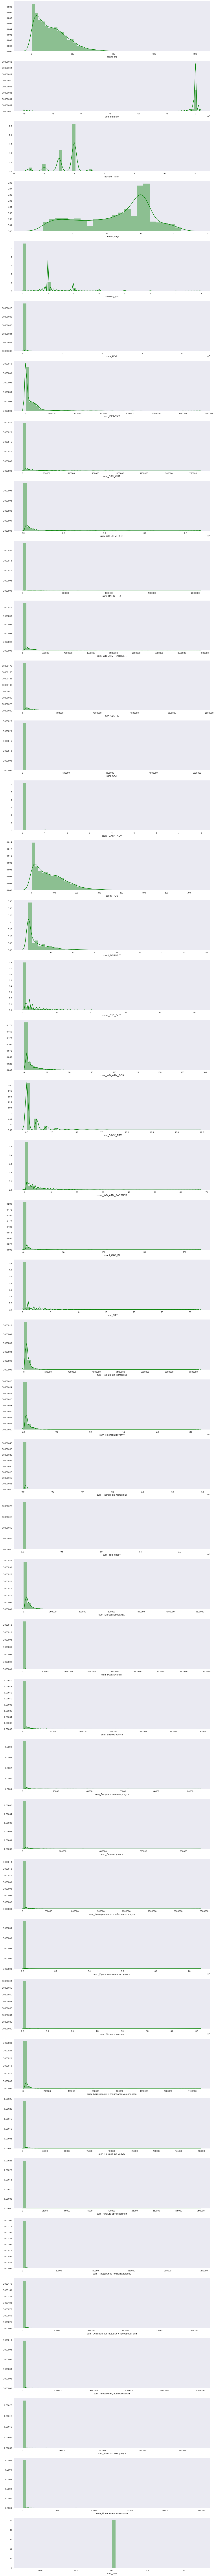

In [17]:
nc_count = len(numerical)
_, axes = plt.subplots(nc_count, 1, figsize=(16, nc_count * 5))

for i, col in enumerate(numerical):
    sns.distplot(train_agg[col], ax=axes[i], color = 'green');

#### Посмотрим как связаны признаки с целевым.

Построим boxplot-ы, описывающее статистики распределения количественных признаков в двух группах: среди лояльных и ушедших клиентов

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


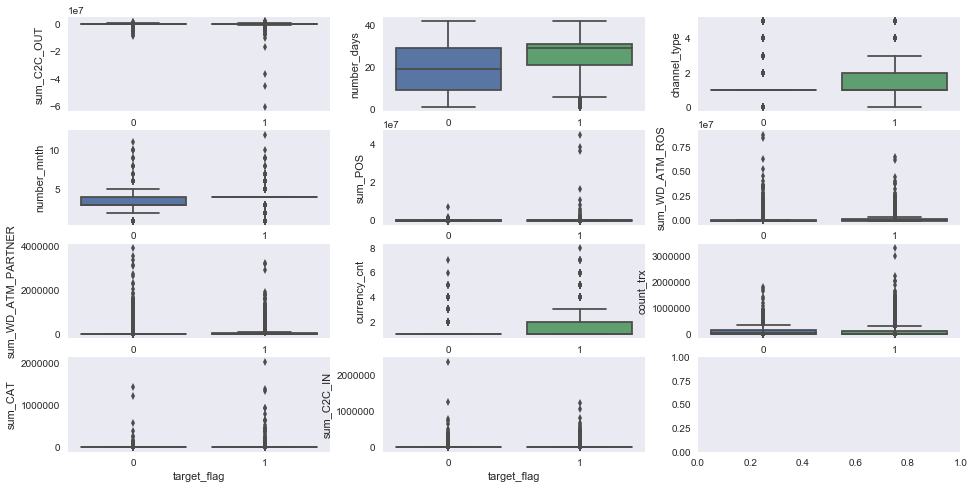

In [18]:
#fig, axes = plt.subplots(nc_count, 1, figsize=(16, nc_count * 5))
features = list(set(train_agg.columns) - set(['sum_Розничные магазины', 'sum_Поставщик услуг',
       'sum_Различные магазины', 'sum_Транспорт', 'sum_Магазины одежды',
       'sum_Развлечения', 'sum_Бизнес услуги', 'sum_Государственные услуги',
       'sum_Личные услуги', 'sum_Коммунальные и кабельные услуги',
       'sum_Профессиональные услуги', 'sum_Отели и мотели',
       'sum_Автомобили и транспортные средства', 'sum_Ремонтные услуги',
       'sum_Аренда автомобилей', 'sum_Продажи по почте/телефону',
       'sum_Оптовые поставщики и производители', 'sum_Авиалинии, авиакомпании',
       'sum_Контрактные услуги', 'sum_Членские организации', 'sum_nan', 'target_flag', 'cl_id', 
        'count_CASH_ADV', 'count_POS', 'count_DEPOSIT',
       'count_C2C_OUT', 'count_WD_ATM_ROS', 'count_BACK_TRX',
       'count_WD_ATM_PARTNER', 'count_C2C_IN', 'count_CAT',]))

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 8))

for idx, feat in  enumerate(features):
    sns.boxplot(x='target_flag', y=feat, data=train_agg, ax=axes[int(idx / 4), idx % 3])
    axes[int(idx / 4), idx % 3].legend()
    axes[int(idx / 4), idx % 3].set_xlabel('target_flag')
    axes[int(idx / 4), idx % 3].set_ylabel(feat);

На глаз наибольшее отличие мы видим для признаков end_balance, currency_cnt, number_days, count_trx. Посмотрим далее на важность признаков с помощью случайного леса (градиентного бустинга).

Посмотрим отдельно на картинки с этими признаками.

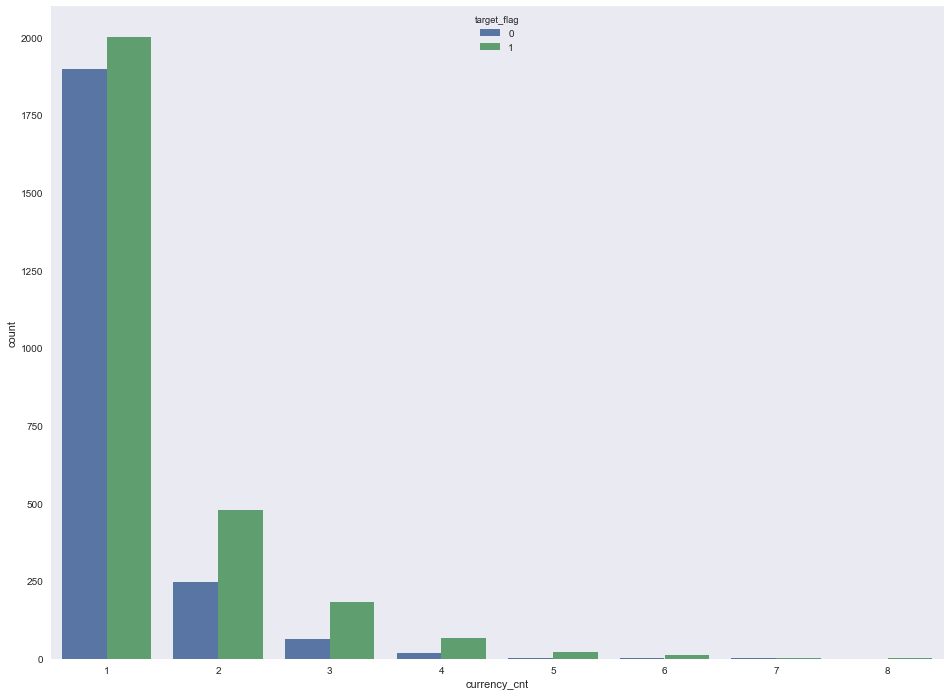

In [19]:
sns.countplot(x='currency_cnt', hue='target_flag', data=train_agg);

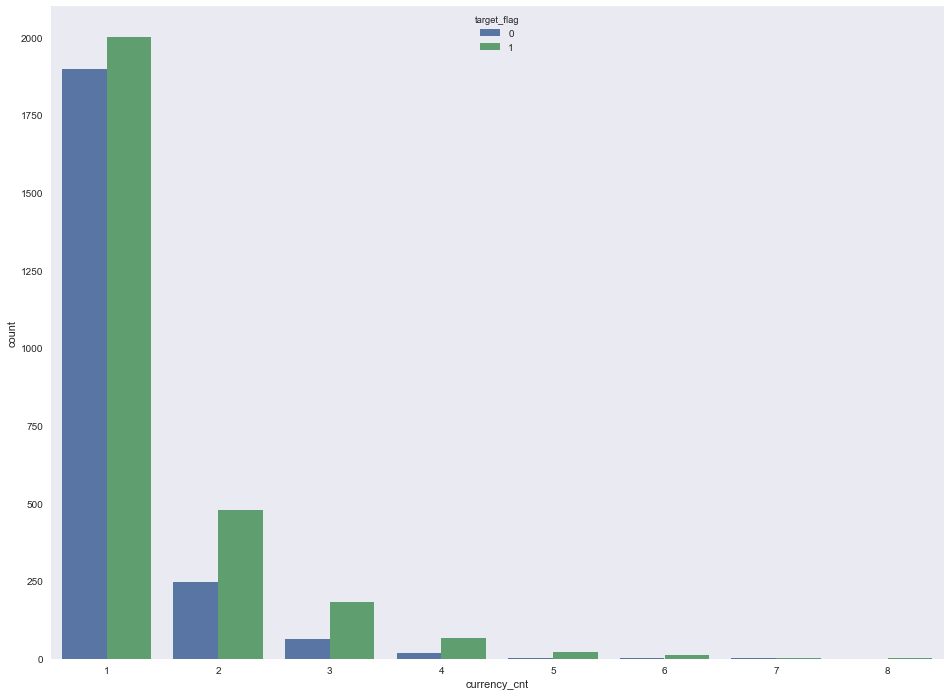

In [22]:
sns.countplot(x='currency_cnt', hue='target_flag', data=train_agg);

In [23]:
train_agg['end_balance'].describe(percentiles=[.10, .30, .65, .80])

count    5.000000e+03
mean    -3.185946e+05
std      1.355864e+06
min     -6.043542e+07
10%     -7.717791e+05
30%     -2.773968e+05
50%     -1.033068e+05
65%     -3.008878e+04
80%     -2.840360e+03
max      1.864947e+06
Name: end_balance, dtype: float64

In [24]:
train_agg['count_trx'].describe(percentiles=[.10, .30, .65, .80])

count    5000.000000
mean       98.102600
std        78.107609
min         1.000000
10%        12.000000
30%        42.000000
50%        83.000000
65%       118.000000
80%       160.000000
max       784.000000
Name: count_trx, dtype: float64

Разобьем на группы count_trx, end_balance

In [97]:
#Количество подобрано "ручками" см. статистики выше
def new_trx(s):
    if s >= 160: 
        return 160
    elif (s >=118 and s<160): 
        return 118
    elif (s >=83 and s<118):
        return 83
    elif (s >=73 and s<83): 
        return 73
    elif (s >=63 and s<73): 
        return 118
    elif (s >=53 and s<63):
        return 53
    elif (s >=42 and s<53): 
        return 42
    elif (s >=32 and s<42): 
        return 32
    elif (s >=22 and s<32): 
        return 22
    elif (s < 22):
        return 12

#Итоговый баласнс

def new_end_balance(s):
    if s > -2840: 
        return 1
    elif (s <=-2840 and s > -10088): 
        return 2
    elif (s <=-10088 and s > -20088): 
        return 3    
    elif (s <=-20088 and s > -30088): 
        return 4
    elif (s <= -30088 and s > -103306): 
        return 5
    elif (s <= -103306 and s > -113306): 
        return 6
    elif (s <= -113306 and s > -123306): 
        return 7
    elif (s <= -123306 and s > -133306): 
        return 8
    elif (s <= -133306 and s > -143306): 
        return 9
    elif (s <= -143306 and s > -153306): 
        return 10
    elif (s <= -153306 and s > -163306): 
        return 11
    elif (s <= -163306 and s > -173306): 
        return 12
    elif (s <= -173306 and s > -183306): 
        return 13
    elif (s <= -183306 and s > -203306): 
        return 14
    elif (s <= -203306): 
        return 15

In [100]:
train_agg['gr_count_trx'] = train_agg['count_trx'].apply(new_trx)
train_agg['new_end_balance'] = train_agg['end_balance'].apply(new_end_balance)

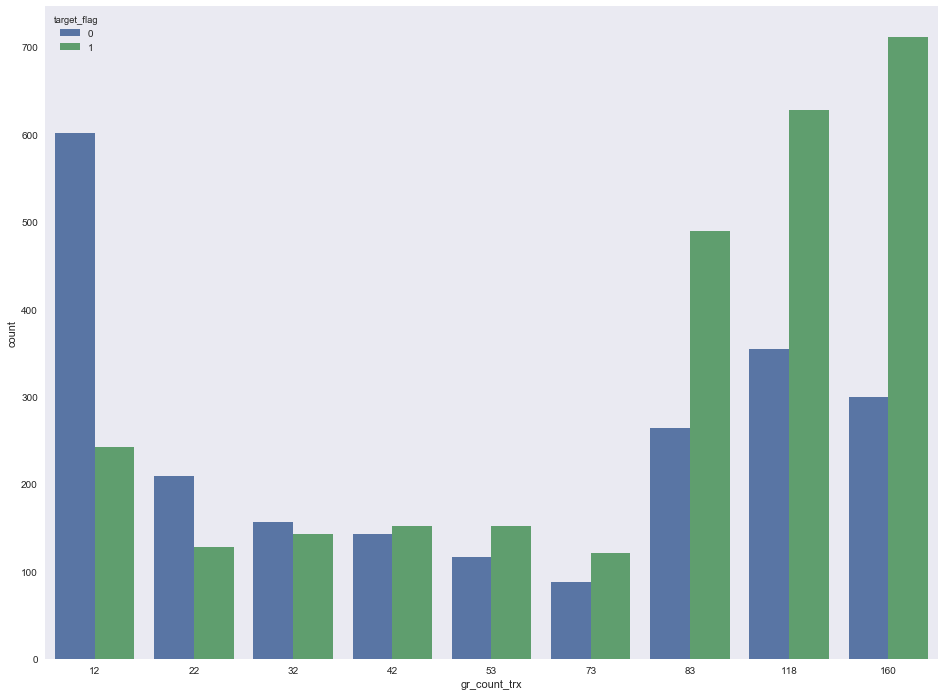

In [101]:
sns.countplot(x='gr_count_trx', hue='target_flag', data=train_agg);

Видно, что при количестве транзакций до 32 количество отказов превышает количество продолжающих пользоваться предложением. После 83 транзакций доля продолжающих пользоваться продуктом практически не меняется. Добавим бинарные признаки "transaction_s_12", "transaction_btw_32_53", "transaction_b_83" 

In [102]:
train_agg['transaction_s_12'] =(train_agg['count_trx'] <=22 ).astype('int')
train_agg['transaction_btw_32_53'] =((train_agg['count_trx'] >=32) & (train_agg['count_trx'] < 53)).astype('int')
train_agg['transaction_b_73'] =(train_agg['count_trx'] >=83 ).astype('int')

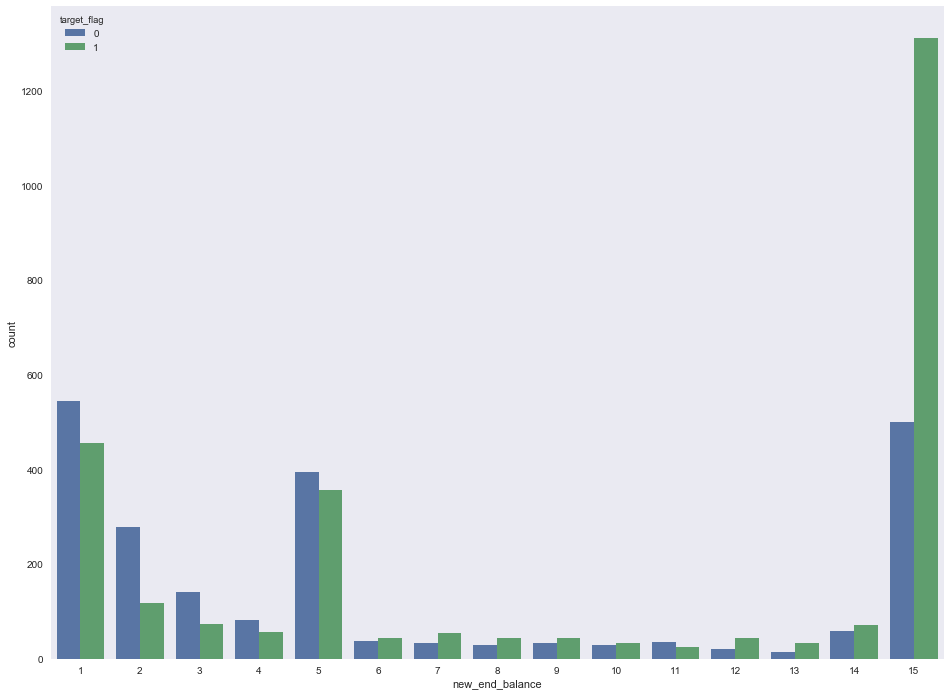

In [103]:
sns.countplot(x='new_end_balance', hue='target_flag', data=train_agg);

Видно, что после группы № 6 доля нелояльных клиентов возрастает. Добавим бинарный признак "End_balance < -30088".

In [104]:
train_agg['End_balance < -113306'] =(train_agg['end_balance'] < -113306).astype('int')

In [105]:
train_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
channel_type                              5000 non-null int64
cl_id                                     5000 non-null int64
count_trx                                 5000 non-null int64
end_balance                               5000 non-null float64
number_mnth                               5000 non-null int64
number_days                               5000 non-null int64
currency_cnt                              5000 non-null int64
sum_POS                                   5000 non-null float64
sum_DEPOSIT                               5000 non-null float64
sum_C2C_OUT                               5000 non-null float64
sum_WD_ATM_ROS                            5000 non-null float64
sum_BACK_TRX                              5000 non-null float64
sum_WD_ATM_PARTNER                        5000 non-null float64
sum_C2C_IN                                5000 non-null float64
sum_CAT  

In [43]:
y1_train = train.groupby('cl_id')['target_flag'].first()
y2_train = np.log(train.groupby('cl_id')['target_sum'].first()+1.0)

X_train = train_agg[features].values
X_test = test_agg[features].values

### Кроссвалидация

In [44]:
kf = list(KFold(5, shuffle = True, random_state = 17).split(X_train, y1_train))

In [45]:
from operator import itemgetter

def report(grid_scores, n_top):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [46]:
param_grid_for_forest = { "n_estimators": np.arange(10, 300, 2),
                          "max_depth": np.arange(1, 20, 1),
                          "min_samples_split": np.arange(2,150,1),
                          "min_samples_leaf": np.arange(2,60,1),
                          "max_features" : np.arange(1,X_train.shape[1],1)
}

In [47]:
grid_search = RandomizedSearchCV(RandomForestClassifier(),error_score='roc-auc', param_distributions=param_grid_for_forest, cv = kf,verbose = 1,random_state = 17)
grid_search.fit(train_agg, y1_train)

report(grid_search.grid_scores_, 3)
#Mean validation score: 0.7734)Mean validation score: 0.7764, 07716,0.7776, 0.7716, 0.7734

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.7min finished


Model with rank: 1
Mean validation score: 0.7738)
Parameters: {'n_estimators': 290, 'min_samples_split': 103, 'min_samples_leaf': 16, 'max_features': 8, 'max_depth': 11}

Model with rank: 2
Mean validation score: 0.7716)
Parameters: {'n_estimators': 68, 'min_samples_split': 112, 'min_samples_leaf': 47, 'max_features': 25, 'max_depth': 17}

Model with rank: 3
Mean validation score: 0.7708)
Parameters: {'n_estimators': 178, 'min_samples_split': 116, 'min_samples_leaf': 18, 'max_features': 61, 'max_depth': 16}



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [49]:
feat_importance = pd.DataFrame(train_agg.columns, columns = ['features'])
feat_importance['value'] = grid_search.best_estimator_.feature_importances_
feat_importance.sort_values('value')

,features,value
53,sum_Аренда автомобилей,0.000000
15,count_CASH_ADV,0.000000
58,sum_Членские организации,0.000000
29,C_balance__,0.000000
59,sum_nan,0.000000
60,new_diff_hours,0.000019
57,sum_Контрактные услуги,0.000028
23,count_CAT,0.000224
14,sum_CAT,0.000325
56,"sum_Авиалинии, авиакомпании",0.000350


In [50]:
%%time

forest_params = {'min_samples_leaf':[1, 3, 5, 7,9,11,13,15],
                 'max_depth': [None] + list(range(5, 25)),
                 #'n_estimators': list(range(1, 20, 5))
                }
forest = RandomForestClassifier(n_jobs=-1, random_state=17, verbose=0)

forest_grid = GridSearchCV(forest, forest_params, scoring='roc_auc', n_jobs=-1,cv=kf, verbose=1)

forest_grid.fit(train_agg, y1_train)

report(forest_grid.grid_scores_, 3)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  1.6min finished


Model with rank: 1
Mean validation score: 0.8470)
Parameters: {'max_depth': 17, 'min_samples_leaf': 13}

Model with rank: 2
Mean validation score: 0.8469)
Parameters: {'max_depth': 11, 'min_samples_leaf': 13}

Model with rank: 3
Mean validation score: 0.8467)
Parameters: {'max_depth': 19, 'min_samples_leaf': 13}

Wall time: 1min 36s


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [51]:
feat_importance = pd.DataFrame(train_agg.columns, columns = ['features'])
feat_importance['value'] = forest_grid.best_estimator_.feature_importances_
feat_importance.sort_values('value')

,features,value
46,sum_Государственные услуги,0.000000
59,sum_nan,0.000000
58,sum_Членские организации,0.000000
57,sum_Контрактные услуги,0.000000
30,D_balance_+,0.000000
23,count_CAT,0.000000
29,C_balance__,0.000000
15,count_CASH_ADV,0.000000
14,sum_CAT,0.000000
60,new_diff_hours,0.000021


### XGBoost 

In [63]:
%%time

xgb1 = XGBClassifier(nthread=-1)
xgb2 = XGBRegressor(nthread=-1)

score1 = np.mean(cross_val_score(
    xgb1, X_train, y1_train, 
    scoring = 'roc_auc', 
    cv = kf, n_jobs = 4
))

score2 = np.mean(cross_val_score(
    xgb2, X_train, y2_train, 
    scoring = 'neg_mean_squared_error', 
    cv = kf, n_jobs = 4
))

print('%.4f, %.4f' % (score1, (-score2) ** 0.5))
#0.8535, 4.0882

0.8506, 4.1011
Wall time: 1min 47s


Лучший результат для 1-ой задачи: 0.8747, полученный этим решением - 0.8504. По 2-ой задаче лучший результат - 3.8440, полученный этим решением - 4.0602.